<h1> Time series prediction, end-to-end </h1>

This notebook illustrates several models to find the next value of a time-series:
<ol>
<li> Linear
<li> DNN
<li> CNN 
<li> RNN
</ol>

In [1]:
# Change these to try this notebook out
BUCKET = "qwiklabs-gcp-01-d3039932f3b6"
PROJECT = "qwiklabs-gcp-01-d3039932f3b6"
REGION = "australia-southeast1"
SEQ_LEN = 50

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['SEQ_LEN'] = str(SEQ_LEN)
os.environ['TFVERSION'] = "1.13"

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [3]:
import tensorflow as tf
print(tf.__version__)

2.6.3


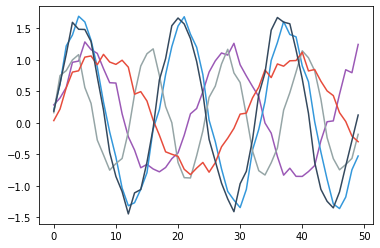

In [5]:
import numpy as np
import seaborn as sns

def create_time_series():
    freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
    ampl = np.random.random() + 0.5  # 0.5 to 1.5
    noise = [np.random.random()*0.3 for i in range(SEQ_LEN)] # -0.3 to +0.3 uniformly distributed
    x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl + noise
    return x

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for ix in range(0, 5):
    # sns.tsplot(create_time_series(), color=flatui[ix % len(flatui)]);  # 5 series
    sns.lineplot(data=create_time_series(), color=flatui[ix % len(flatui)]);  # 5 series

In [6]:
def to_csv(filename, N):
    with open(filename, 'w') as ofp:
        for lineno in range(0, N):
            seq = create_time_series()
            line = ",".join(map(str, seq))
            ofp.write(line + '\n')

import os
try:
    os.makedirs("data/sines/")
except OSError:
    pass

np.random.seed(1) # makes data generation reproducible

to_csv("data/sines/train-1.csv", 1000)  # 1000 sequences
to_csv("data/sines/valid-1.csv", 250)

In [7]:
!head -3 data/sines/*-1.csv

==> data/sines/train-1.csv <==
3.431244520346599e-05,0.4612394382104329,0.750117333010706,1.002669376511136,1.2076602884326402,1.323506095651725,1.2917387402358318,1.1764893692792453,0.886910345640603,0.6411525584650162,0.13022616813814403,-0.04087557975624989,-0.64056082916097,-0.7308413932916386,-1.0019909717193467,-1.0483403299809841,-1.1477784066127428,-0.9920536687688593,-0.5735623980981127,-0.20876600013275354,-0.04353401093422207,0.4448081587286241,0.852311158877592,1.1544049946506432,1.124500783220232,1.2198949242663033,1.2542345078878991,1.348212988041884,0.8933280758140663,0.6876422148460588,0.4931601512698732,-0.009206099524738082,-0.3205687472911766,-0.742583738874477,-0.8613371947565367,-0.9461685863974377,-1.2073519868002527,-0.8895532550825337,-0.6144488415480625,-0.39713542151217374,-0.18923575720760066,0.33744428272940225,0.49615270709044407,0.9201515973512377,1.3047620284915646,1.2692019873446236,1.3048558847266711,1.1798764955714098,0.9612944770102272,0.8835284601061

<h3> Train model locally </h3>

Make sure the code works as intended.

In [8]:
%%bash
DATADIR=$(pwd)/data/sines
OUTDIR=$(pwd)/trained/sines
rm -rf $OUTDIR
gcloud ai-platform local train \
    --module-name=sinemodel.task \
    --package-path=${PWD}/sinemodel \
    -- \
    --train_data_path="${DATADIR}/train-1.csv" \
    --eval_data_path="${DATADIR}/valid-1.csv"  \
    --output_dir=${OUTDIR} \
    --model=rnn --train_steps=10 --sequence_length=$SEQ_LEN

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jupyter/training-data-analyst/courses/machine_learning/deepdive/09_sequence_keras/sinemodel/task.py", line 123, in <module>
    model.train_and_evaluate(output_dir, hparams)
  File "/home/jupyter/training-data-analyst/courses/machine_learning/deepdive/09_sequence_keras/sinemodel/model.py", line 155, in train_and_evaluate
    tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
AttributeError: module 'tensorboard.summary._tf.summary' has no attribute 'FileWriterCache'


CalledProcessError: Command 'b'DATADIR=$(pwd)/data/sines\nOUTDIR=$(pwd)/trained/sines\nrm -rf $OUTDIR\ngcloud ai-platform local train \\\n    --module-name=sinemodel.task \\\n    --package-path=${PWD}/sinemodel \\\n    -- \\\n    --train_data_path="${DATADIR}/train-1.csv" \\\n    --eval_data_path="${DATADIR}/valid-1.csv"  \\\n    --output_dir=${OUTDIR} \\\n    --model=rnn --train_steps=10 --sequence_length=$SEQ_LEN\n'' returned non-zero exit status 1.

<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine with more data.

In [10]:
import shutil
shutil.rmtree(path = "data/sines", ignore_errors = True)
os.makedirs("data/sines/")
np.random.seed(1) # makes data generation reproducible
for i in range(0,10):
    to_csv("data/sines/train-{}.csv".format(i), 1000)  # 1000 sequences
    to_csv("data/sines/valid-{}.csv".format(i), 250)

In [11]:
%%bash
gsutil -m rm -rf gs://${BUCKET}/sines/*
gsutil -m cp data/sines/*.csv gs://${BUCKET}/sines

CommandException: 1 files/objects could not be removed.
Copying file://data/sines/train-0.csv [Content-Type=text/csv]...
Copying file://data/sines/train-1.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-0.csv [Content-Type=text/csv]...
Copying file://data/sines/train-3.csv [Content-Type=text/csv]...
Copying file://data/sines/train-4.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-8.csv [Content-Type=text/csv]...
Copying file://data/sines/train-2.csv [Content-Type=text/csv]...
Copying file://data/sines/train-6.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-2.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-1.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-5.csv [Content-Type=text/csv]...
Copying file://data/sines/train-9.csv [Content-Type=text/csv]...
Copying file://data/sines/train-7.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-3.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-6.

In [12]:
%%bash
# for MODEL in linear dnn cnn rnn rnn2; do
for MODEL in rnn rnn2; do
    OUTDIR=gs://${BUCKET}/sinewaves/${MODEL}
    JOBNAME=sines_${MODEL}_$(date -u +%y%m%d_%H%M%S)
    gsutil -m rm -rf $OUTDIR
    gcloud ai-platform jobs submit training $JOBNAME \
        --region=$REGION \
        --module-name=sinemodel.task \
        --package-path=${PWD}/sinemodel \
        --job-dir=$OUTDIR \
        --scale-tier=BASIC \
        --runtime-version=$TFVERSION \
        -- \
        --train_data_path="gs://${BUCKET}/sines/train*.csv" \
        --eval_data_path="gs://${BUCKET}/sines/valid*.csv"  \
        --output_dir=$OUTDIR \
        --train_steps=3000 --sequence_length=$SEQ_LEN --model=$MODEL
done

jobId: sines_rnn_220319_033542
state: QUEUED
jobId: sines_rnn2_220319_033549
state: QUEUED


Removing gs://qwiklabs-gcp-01-d3039932f3b6/sinewaves/rnn/packages/b84ef0da7cec25ff7bb4e16ed388a507e15f06cd8405a796f146709ae15adef3/sinemodel-0.0.0.tar.gz#1647660914107212...
/ [1/1 objects] 100% Done                                                       
Operation completed over 1 objects.                                              
Job [sines_rnn_220319_033542] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe sines_rnn_220319_033542

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs sines_rnn_220319_033542
Removing gs://qwiklabs-gcp-01-d3039932f3b6/sinewaves/rnn2/packages/a2bc37aeec69fcc2a726608fe810335591fe72c8a2f4f43d6742a273f95cc6ea/sinemodel-0.0.0.tar.gz#1647660933911963...
/ [1/1 objects] 100% Done                                                       
Operation completed over 1 objects.                                              
Job [sines_rnn2_

## Monitor training with TensorBoard

Use this cell to launch tensorboard. If tensorboard appears blank try refreshing after 5 minutes

In [14]:
%load_ext tensorboard

In [16]:
BUCKET

'qwiklabs-gcp-01-d3039932f3b6'

In [15]:
# from google.datalab.ml import TensorBoard
# TensorBoard().start("gs://{}/sinewaves".format(BUCKET))

In [20]:
%tensorboard --logdir "gs://qwiklabs-gcp-01-d3039932f3b6/sinewaves/*"

In [19]:
#for pid in TensorBoard.list()["pid"]:
#    TensorBoard().stop(pid)
#    print("Stopped TensorBoard with pid {}".format(pid))

## Results

When I ran it, these were the RMSEs that I got for different models:

| Model | Sequence length | # of steps | Minutes | RMSE |
| --- | ----| --- | --- | --- | 
| linear | 50 | 3000 | 10 min | 0.150 |
| dnn | 50 | 3000 | 10 min | 0.101 |
| cnn | 50 | 3000 | 10 min | 0.105 |
| rnn | 50 | 3000 | 11 min | 0.100 |
| rnn2 | 50 | 3000 | 14 min |0.105 |
| rnnN | 50 | 3000 | 15 min | 0.097 |

### Analysis
You can see there is a significant improvement when switching from the linear model to non-linear models. But within the the non-linear models (DNN/CNN/RNN) performance for all is pretty similar. 

Perhaps it's because this is too simple of a problem to require advanced deep learning models. In the next lab we'll deal with a problem where an RNN is more appropriate.

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License